<a href="https://colab.research.google.com/github/ahmadizza/Tweet-Classification-for-Disaster-Information-Naive-Bayes-Log.-Reg.-/blob/main/Tweet_Classification_for_Disaster_Information_(Naive_Bayes_%26_Log_Reg_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import string
import nltk
import time
import re
import os

from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk import word_tokenize, pos_tag
from scipy.sparse import hstack
from collections import Counter

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

np.random.seed(1611)
plt.style.use('default')    # Reset style matplotlib
plt.rcdefaults()            # Reset rcParams ke default
sns.reset_defaults()        # Reset style seaborn

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [ ]:
try:
    df_train = pd.read_csv("https://raw.githubusercontent.com/Jepees/NLP-with-Disaster-Tweets/refs/heads/main/Dataset/train.csv")
    df_test = pd.read_csv("https://raw.githubusercontent.com/Jepees/NLP-with-Disaster-Tweets/refs/heads/main/Dataset/test.csv")
except:
    df_train = pd.read_csv("https://drive.google.com/uc?id=1ihd1SGi31mKs6u-UhTSh4oV4HwukGzkU")
    df_test = pd.read_csv("https://drive.google.com/uc?id=1EmAmpoohDoUzN_vTj68XGL1e2GyHWm5N")


print(f"total data train: {df_train.shape[0]}\ntotal data test : {df_test.shape[0]}")

total data train: 7613
total data test : 3263


## Exploratory Data

In [ ]:
df_train.sample(5)

,id,keyword,location,text,target
3849,5477,flames,houstn,that new lil b x chance is nothing but flames,0
1583,2285,cliff%20fall,Inside your mind.,Photographer Brian Ruebs endures 4500-feet cli...,0
6460,9242,sunk,mainly California,why wasn't this warship sunk? CNN: First ...,1
2715,3900,devastated,PG Chillin!,Man Currensy really be talkin that talk... I'd...,1
5189,7408,obliterated,#freegucci,Me- Don't bother calling or texting me because...,0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
df_train['target'].value_counts()

,count
target,
0,4342
1,3271


In [ ]:
df_train.duplicated().sum()

np.int64(0)

In [ ]:
df_train.isnull().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


In [ ]:
df_train = df_train.drop(['location','keyword'],axis=1)
df_test = df_test.drop(['location','keyword'],axis=1)

df_train.sample(6)

,id,text,target
6534,9345,@thoutaylorbrown I feel like accidents are jus...,0
3275,4700,Tomorrow kick off your weekend with drinks &am...,0
5753,8213,Riot Kit Bah - part of the new concept Gear co...,0
6850,9818,@crazyindapeg @VETS78734 completely understand...,0
3783,5373,@BrookTekle_ didn't look like a murder scene j...,1
7465,10681,Driver rams car into Israeli soldiers wounds 3...,1


In [ ]:
df_train[df_train['target'] == 0]['target'].value_counts().iloc[0]

np.int64(4342)

In [ ]:
print(f"total tweet tentang bencana      : {df_train['target'].value_counts().iloc[1]} | {round(100*((df_train['target'].value_counts().iloc[1]) / (df_train.shape[0])), 2)}%")
print(f"total tweet bukan tentang bencana: {df_train['target'].value_counts().iloc[0]} | {round(100*((df_train['target'].value_counts().iloc[0]) / (df_train.shape[0])), 2)}%")


total tweet tentang bencana      : 3271 | 42.97%
total tweet bukan tentang bencana: 4342 | 57.03%


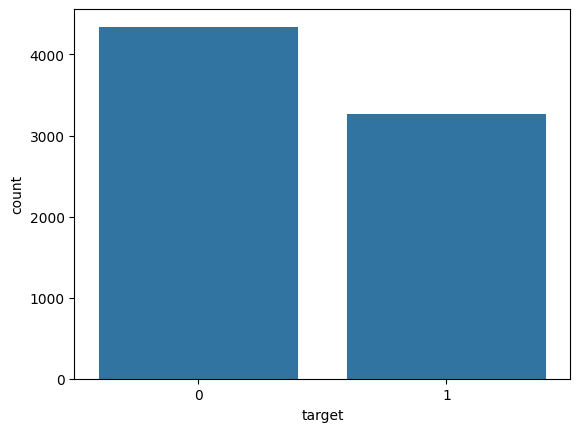

In [ ]:
sns.countplot(x='target', data=df_train)
plt.show()

In [ ]:
print("contoh tweet bukan tentang bencana:")
for i in range(5):
    print(f"{i+1}. {df_train[df_train['target'] == 0].sample(10)['text'].values[i]}")

print("\ncontoh tweet tentang bencana:")
for i in range(5):
    print(f"{i}. {df_train[df_train['target'] == 1].sample(10)['text'].values[i]}")

contoh tweet bukan tentang bencana:
1. @UABStephenLong @courtlizcamp Total tweet fail! You are so beautiful inside and out Blaze On!
2. Shark boy and lava girl for the third time today. I guess this is what having kids feelings like. ??????
3. Speaking of memorable debates: 60-Second Know-It-All: Ronald Reagan's landslide romp on Election Day in 1980 m... http://t.co/2XOhtjQJWh
4. My brains going to explode i need to leave this house. Ill be out smoking packs if you need me
5. YOUR PHONE IS SPYING ON YOU! Hidden Back Door NSA Data Mining Software | THE FINANCIAL ARMAGEDDON BLOG http://t.co/qyCw5JJaj1

contoh tweet tentang bencana:
0. Forest fire near La Ronge Sask. Canada
1. 70 Years After Atomic Bombs Japan Still Struggles With War Past: The anniversary of the devastation wrought b... http://t.co/iTBJ6DKRZI
2. The Dress Memes Have Officially Exploded On The Internet http://t.co/3drSmxw3cr
3. Russian 'food crematoria' provoke outrage amid crisis famine memories http://t.co/h6Z7hXUqtu v

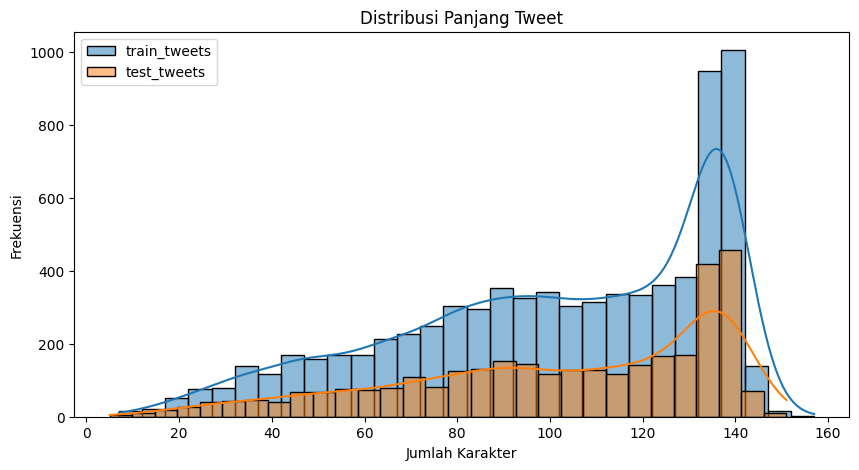

In [ ]:
# Plot distribusi panjang tweet
plt.figure(figsize=(10, 5))
sns.histplot(df_train['text'].apply(len), bins=30, kde=True, label="train_tweets")
sns.histplot(df_test['text'].apply(len), bins=30, kde=True, label="test_tweets")
plt.title('Distribusi Panjang Tweet')
plt.xlabel('Jumlah Karakter')
plt.ylabel('Frekuensi')
plt.legend()
plt.show()

In [ ]:
# cleaning the text
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

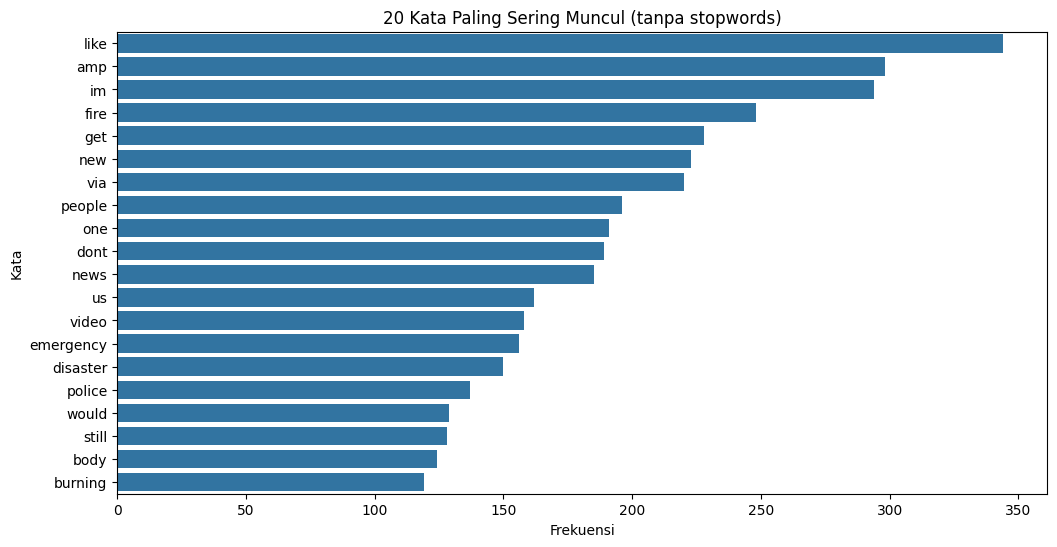

In [ ]:
stop_words = set(stopwords.words('english'))
all_words = []

for text in df_train['text']:
    words = clean_text(text).split()
    words = [word for word in words if word not in stop_words]
    all_words.extend(words)

# Ambil 20 kata paling sering
word_freq = Counter(all_words).most_common(20)
words, freqs = zip(*word_freq)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=list(freqs), y=list(words))
plt.title('20 Kata Paling Sering Muncul (tanpa stopwords)')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()

## Data Preprocessing

In [ ]:
# cleaning the text
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and train datasets
df_train['clean_text'] = df_train['text'].apply(lambda x: clean_text(x))
df_test['clean_text'] = df_test['text'].apply(lambda x: clean_text(x))

# updated text
print("contoh tweet bukan tentang bencana yang sudah dibersihkan:")
for i in range(5):
    print(f"{i+1}. {df_train[df_train['target'] == 0].sample(10)['clean_text'].values[i]}")


contoh tweet bukan tentang bencana yang sudah dibersihkan:
1. dont like those head first slides especially into home  danger
2. a look at state actions a year after fergusonûªs upheaval  
3. tornadogiveaway åê thebookclub åê join in  
4. new explosionproof tempered glass screen protector film for blackberry   full read byû  
5.  yes god doessnt change  he says not to rejoice over the fall of people or calamities like wild fires  ect  you wanna be punished


In [ ]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def tokenator(text):
    tokens = nltk.word_tokenize(text)  # Tokenisasi
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words] # Stopword removal + lemmatizing
    # tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]  # Stopword removal + stemming
    tokens = " ".join(tokens)
    return tokens


df_train['tokenize_text'] = df_train['clean_text'].apply(tokenator)
df_test['tokenize_text'] = df_test['clean_text'].apply(tokenator)

In [ ]:
df_train.sample(10)

,id,text,target,clean_text,tokenize_text
3404,4874,See these guys reaching the front foot out loa...,0,see these guys reaching the front foot out loa...,see guy reaching front foot loading shoulder s...
385,558,Los Angeles Times: Arson suspect linked to 30 ...,1,los angeles times arson suspect linked to fir...,los angeles time arson suspect linked fire cau...
4967,7078,Ever since my Facebook #Mets meltdown after th...,0,ever since my facebook mets meltdown after the...,ever since facebook mets meltdown padre fiasco...
5953,8504,@camilacabello97 NOW IM INTERNALLY SCREAMING,0,now im internally screaming,im internally screaming
4753,6762,Expect gusty winds heavy downpours and lightni...,1,expect gusty winds heavy downpours and lightni...,expect gusty wind heavy downpour lightning mov...
1228,1769,Watching Xela firefighters struggle to save bu...,1,watching xela firefighters struggle to save bu...,watching xela firefighter struggle save burnin...
7142,10234,@songhey89 well I'm also gay but girls like so...,0,well im also gay but girls like some too so ...,well im also gay girl like predict tsunami amp...
1038,1504,@baskgod body bags,0,baskgod body bags,baskgod body bag
6301,9002,@Stretcher @Rexyy @invalid @Towel let's have b...,0,stretcher rexyy invalid towel lets have babies,stretcher rexyy invalid towel let baby
6836,9791,@BoyInAHorsemask its a panda trapped in a dogs...,1,boyinahorsemask its a panda trapped in a dogs ...,boyinahorsemask panda trapped dog body


## Text Vectorization

In [ ]:
# Inisialisasi vectorizer
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

# Fit dan transform teks
X_count = count_vectorizer.fit_transform(df_train['tokenize_text'])
X_tfidf = tfidf_vectorizer.fit_transform(df_train['tokenize_text'])

# Label
y = df_train['target']

print("Shape CountVectorizer:", X_count.shape)
print("Shape TFIDFVectorizer:", X_tfidf.shape)

Shape CountVectorizer: (7613, 15200)
Shape TFIDFVectorizer: (7613, 15200)


In [ ]:
# Split data: 80% train, 20% test
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=12, stratify=y)

## Training Models Logistic Regression

In [ ]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Prediksi
y_pred_lr = lr_model.predict(X_val)

# print("\n=== Logistic Regression ===")
print(classification_report(y_val, y_pred_lr))
# print(confusion_matrix(y_val, y_pred_lr))
print("Akurasi:", accuracy_score(y_val, y_pred_lr))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       869
           1       0.85      0.66      0.74       654

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523

Akurasi: 0.8030203545633617


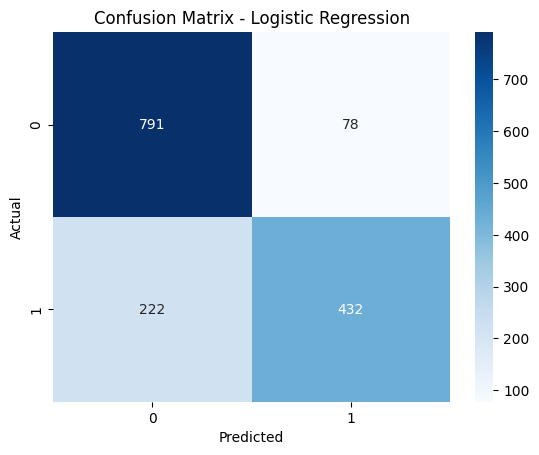

In [ ]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_cm(y_val, y_pred_lr, "Confusion Matrix - Logistic Regression")

### Tuning

#### Grid Search

In [ ]:
# 2. Buat pipeline: scaling + logistic regression
pipeline = Pipeline([
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced'))
], memory=joblib.Memory(location='./cache'))

# 3. Parameter grid yang valid
param_grid = [
    {
        'logreg__penalty': ['l1'],
        'logreg__C': [0.01, 0.1, 1, 10, 100],
        'logreg__solver': ['liblinear', 'saga']
    },
    {
        'logreg__penalty': ['l2'],
        'logreg__C': [0.01, 0.1, 1, 10, 100],
        'logreg__solver': ['liblinear', 'lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
    },
    {
        'logreg__penalty': ['elasticnet'],
        'logreg__C': [0.01, 0.1, 1, 10, 100],
        'logreg__solver': ['saga'],
        'logreg__l1_ratio': [0.1, 0.5, 0.9]
    }
]

start_time = time.time()
# 4. Grid search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# 5. Hasil
print("Best parameters:", grid_search.best_params_)
print("Best cross-val accuracy:", grid_search.best_score_)

# 6. Evaluasi di test set
y_pred = grid_search.predict(X_val)
print("\nClassification report on test set:")
print(classification_report(y_val, y_pred))

end_time = time.time()

# Hitung durasi
elapsed_time = end_time - start_time
print(f"\nWaktu eksekusi: {elapsed_time:.6f} detik")

Fitting 5 folds for each of 55 candidates, totalling 275 fits
Best parameters: {'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Best cross-val accuracy: 0.7489938010286741

Classification report on test set:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       869
           1       0.80      0.75      0.77       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.81      1523
weighted avg       0.81      0.81      0.81      1523


Waktu eksekusi: 7112.065330 detik


#### n-grmas

In [ ]:
# Inisialisasi vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)

# Fit dan transform teks
X_tfidf = tfidf_vectorizer.fit_transform(df_train['tokenize_text'])

# Label
y = df_train['target']

print(f"Shape TFIDFVectorizer: {X_train.shape}\n")

Shape TFIDFVectorizer: (6090, 15200)



In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=12, stratify=y)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Prediksi
y_pred_lr = lr_model.predict(X_val)

# print("\n=== Logistic Regression ===")
print(classification_report(y_val, y_pred_lr))
# print(confusion_matrix(y_val, y_pred_lr))
print("Akurasi:", accuracy_score(y_val, y_pred_lr))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       869
           1       0.84      0.68      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523

Akurasi: 0.8069599474720945


#### feature selection

In [ ]:
selector = SelectKBest(chi2, k=3000)
X_selected = selector.fit_transform(X_tfidf, y)

# Label
y = df_train['target']

X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=12, stratify=y)

In [ ]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', C=1, penalty="l2", solver='liblinear')

# Gunakan stratified fold agar proporsi label stabil di tiap fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# Tentukan metrik yang ingin dicek
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Lakukan cross-validation
cv_results = cross_validate(lr_model, X_train, y_train, cv=cv, scoring=scoring)

# Tampilkan hasil per metrik
for metric in scoring:
    mean_score = cv_results[f'test_{metric}'].mean()
    std_score = cv_results[f'test_{metric}'].std()
    print(f"{metric.upper()} : {mean_score:.4f} (+/- {std_score:.4f})")

ACCURACY : 0.8164 (+/- 0.0091)
PRECISION : 0.8092 (+/- 0.0079)
RECALL : 0.7493 (+/- 0.0169)
F1 : 0.7781 (+/- 0.0126)


In [ ]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', C=1, penalty="l2", solver='liblinear')
lr_model.fit(X_train, y_train)

# Prediksi
y_pred_lr = lr_model.predict(X_val)

# print("\n=== Logistic Regression ===")
print(classification_report(y_val, y_pred_lr))
# print(confusion_matrix(y_val, y_pred_lr))
print("Akurasi:", accuracy_score(y_val, y_pred_lr))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       869
           1       0.82      0.79      0.81       654

    accuracy                           0.84      1523
   macro avg       0.84      0.83      0.83      1523
weighted avg       0.84      0.84      0.84      1523

Akurasi: 0.8371634931057124


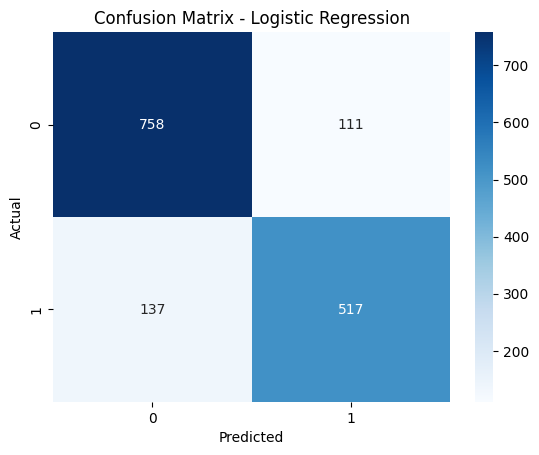

In [ ]:
plot_cm(y_val, y_pred_lr, "Confusion Matrix - Logistic Regression")


In [ ]:
# joblib.dump({
#     'model': lr_model,
#     'vectorizer': tfidf_vectorizer,
#     'selector': selector
# }, './Saved Models/disaster_classifier.pkl')

In [ ]:
# saved = joblib.load('disaster_classifier.pkl')
# lr_model = saved['model']
# tfidf_vectorizer = saved['vectorizer']
# selector = saved.get('selector')

## Training Model Naive Bayes

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [ ]:
y_pred_nb = nb_model.predict(X_val)

# print("\n=== Naive Bayes ===")
print(classification_report(y_val, y_pred_nb))
# print(confusion_matrix(y_val, _nb_lr))
print("Akurasi:", accuracy_score(y_val, y_pred_nb))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86       869
           1       0.91      0.67      0.77       654

    accuracy                           0.83      1523
   macro avg       0.85      0.81      0.82      1523
weighted avg       0.84      0.83      0.82      1523

Akurasi: 0.8273145108338805


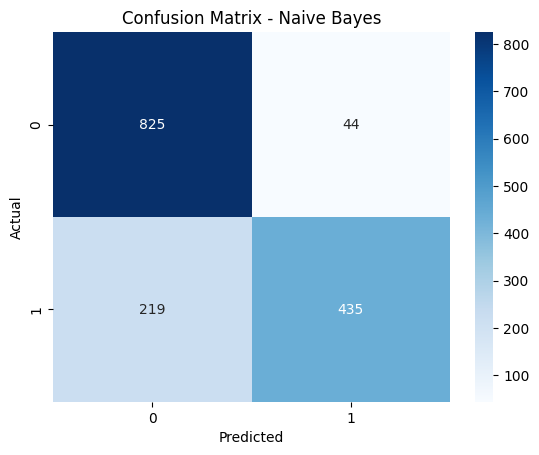

In [ ]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_val, y_pred_nb)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_cm(y_val, y_pred_nb, "Confusion Matrix - Naive Bayes")

### Tuning

#### Grid Search

In [ ]:
# Parameter grid
param_grid = [
    {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
        'fit_prior': [True],
        'class_prior': [[0.5, 0.5], [0.7, 0.3], [0.9, 0.1]]
    },
    {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
        'fit_prior': [False]
        # Saat fit_prior=False, class_prior tidak digunakan (harus None)
    }
]


# Gunakan GridSearchCV
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit model ke data latih
grid_search.fit(X_train, y_train)

# Cetak hasil terbaik
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Uji model terbaik pada data test
best_nb = grid_search.best_estimator_
y_pred = best_nb.predict(X_val)

print("\n=== Naive Bayes (After Tuning) ===")
print(classification_report(y_val, y_pred))
print("Test Accuracy:", accuracy_score(y_val, y_pred))

Best parameters: {'alpha': 0.01, 'class_prior': [0.5, 0.5], 'fit_prior': True}
Best cross-validation accuracy: 0.8435139573070607

=== Naive Bayes (After Tuning) ===
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       869
           1       0.86      0.81      0.83       654

    accuracy                           0.86      1523
   macro avg       0.86      0.85      0.86      1523
weighted avg       0.86      0.86      0.86      1523

Test Accuracy: 0.8594878529218647


#### Model dengan parameter tebaik

In [ ]:
# Buat model baru dengan parameter terbaik
best_params = {
    'alpha': 0.01,
    'fit_prior': True,
    'class_prior': [0.5, 0.5]
}

final_nb = MultinomialNB(**best_params)

# Latih model pada data latih
final_nb.fit(X_train, y_train)

# Evaluasi model pada data uji
y_pred_final = final_nb.predict(X_val)

print("\n=== Final Naive Bayes Model ===")
print(classification_report(y_val, y_pred_final))
print("Test Accuracy:", accuracy_score(y_val, y_pred_final))


=== Final Naive Bayes Model ===
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       869
           1       0.86      0.81      0.83       654

    accuracy                           0.86      1523
   macro avg       0.86      0.85      0.86      1523
weighted avg       0.86      0.86      0.86      1523

Test Accuracy: 0.8594878529218647


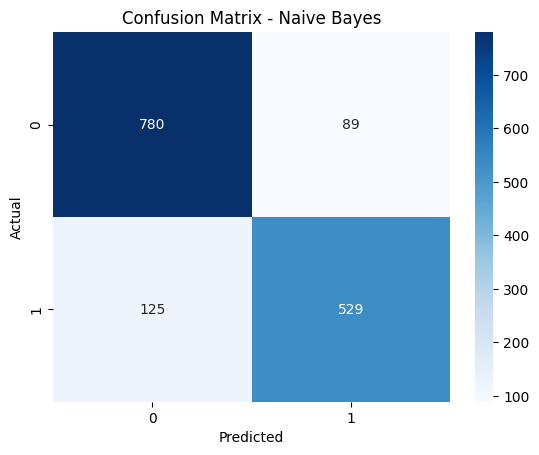

In [ ]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_val, y_pred_final)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_cm(y_val, y_pred_nb, "Confusion Matrix - Naive Bayes")

## Analisis Perbandingan Hasil Prediksi Model degan Label Sebenarnya

In [ ]:
df_val = df_train.copy()


X_tfidf = tfidf_vectorizer.transform(df_val['tokenize_text'])
X_selected = selector.transform(X_tfidf)

df_val['predicted_lr'] = lr_model.predict(X_selected)
df_val['predicted_nb'] = final_nb.predict(X_selected)

df_val = df_val[['text', 'target', 'predicted_lr', 'predicted_nb']]
df_val = df_val[(df_val['target'] != df_val['predicted_lr']) & (df_val['target'] != df_val['predicted_nb'])]

df_val_real = df_val[df_val['target'] == 1].reset_index(drop=True)
df_val_fake = df_val[df_val['target'] == 0].reset_index(drop=True)

df_val_real

,text,target,predicted_lr,predicted_nb
0,I'm on top of the hill and I can see a fire in...,1,0,0
1,I was in a horrible car accident this past Sun...,1,0,0
2,only had a car for not even a week and got in ...,1,0,0
3,@AlexAllTimeLow awwww they're on an airplane a...,1,0,0
4,Early wake up call from my sister begging me t...,1,0,0
...,...,...,...,...
530,the sunset boys wreck my bed original 1979 u...,1,0,0
531,@GeorgeFoster72 and The Wreck of the Edmund Fi...,1,0,0
532,Wreck with road blockage Woodward Avenue North...,1,0,0
533,Omg if Cain dies i will be an emotional wreck ...,1,0,0


berikut adalah contoh tweet yang sama2 salah diprediksi oleh kedua model

In [ ]:
for i in range(55, 65):
    print(f"Tweet: {df_val_real['text'].iloc[i]}")
    print(f"Target: 1 (bencana), Predicted: 0 (bukan bencana)")
    print("-" * 50)

Tweet: it wasnt a very big stab but it was a deep stab and theres like blood everwhe
Target: 1 (bencana), Predicted: 0 (bukan bencana)
--------------------------------------------------
Tweet: White family (supposedly representing America's GREAT values ) gets blown up in a horrible CGI nuclear strike..... LMFAOOOO!!!!!!!!!!!!
Target: 1 (bencana), Predicted: 0 (bukan bencana)
--------------------------------------------------
Tweet: On #ThisDayInHistory in 1862 Confederate ship blown up by crew. Read More http://t.co/IW7ELSzIfZ via @History
Target: 1 (bencana), Predicted: 0 (bukan bencana)
--------------------------------------------------
Tweet: 'If a truckload of soldiers will be blown up nobody panics but when one little lion dies everyone loses their mind'
http://t.co/wjNTaOkdHf
Target: 1 (bencana), Predicted: 0 (bukan bencana)
--------------------------------------------------
Tweet: Even though BSG had been sufficiently hyped up for me in all the years I somehow delayed watching 

In [ ]:
for i in range(70, 80):
    print(f"Tweet: {df_val_fake['text'].iloc[i]}")
    print(f"Target: 1 (bencana), Predicted: 0 (bukan bencana)")
    print("-" * 50)

Tweet: cPanel Crash Course http://t.co/bIRKbje23e #course http://t.co/buZWJmW49e
Target: 1 (bencana), Predicted: 0 (bukan bencana)
--------------------------------------------------
Tweet: Kinetic Typography Crash Course (After Effects) (Video) http://t.co/fL8gCi84Aj #course http://t.co/dVONWIv3l1
Target: 1 (bencana), Predicted: 0 (bukan bencana)
--------------------------------------------------
Tweet: @johndcgow heard this few days ago while driving and near crashed the car from laughing to much
Target: 1 (bencana), Predicted: 0 (bukan bencana)
--------------------------------------------------
Tweet: I crashed my car into a parked car the other day... #modestmouseremix #truestory
Target: 1 (bencana), Predicted: 0 (bukan bencana)
--------------------------------------------------
Tweet: Had a minute alone with my crush??...it was an overrated experience...smh
Target: 1 (bencana), Predicted: 0 (bukan bencana)
--------------------------------------------------
Tweet: awwww Baby Walter 

## POS tagging + interpretabilitas

Menggunakan POS tagging atau sequence labeling untuk menemukan informasi penting seperti lokasi bencana dalam tweet.

untuk memperkaya interpretasi, seperti:
- Lokasi kejadian bencana
- Objek/korban/penyebab
- Informasi pendukung dari struktur kalimat

In [ ]:
disaster_df = df_train[df_train['target'] == 1].copy()
disaster_df = disaster_df[['text']]
disaster_df = disaster_df.reset_index(drop=True)
disaster_df

,text
0,Our Deeds are the Reason of this #earthquake M...
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...
...,...
3266,Two giant cranes holding a bridge collapse int...
3267,@aria_ahrary @TheTawniest The out of control w...
3268,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
3269,Police investigating after an e-bike collided ...


### POS Tagging

In [ ]:
df_POS = disaster_df.copy()
df_POS

,text
0,Our Deeds are the Reason of this #earthquake M...
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...
...,...
3266,Two giant cranes holding a bridge collapse int...
3267,@aria_ahrary @TheTawniest The out of control w...
3268,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
3269,Police investigating after an e-bike collided ...


In [ ]:
def extract_proper_nouns(text):
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    proper_nouns = [word for word, tag in tagged if tag in ['NNP', 'NNPS']]
    return proper_nouns

# Contoh penggunaan di beberapa tweet bencana
df_POS['proper_nouns'] = df_POS['text'].apply(extract_proper_nouns)

# Tampilkan beberapa hasil
df_POS.sample(5, random_state=42)

,text,proper_nouns
1644,Nearly 50 thousand people affected by floods i...,[Paraguay]
134,Vladimir Putin Issues Major Warning But Is It ...,"[Vladimir, Putin, Issues, Major, Too, Late, Ar..."
411,@DoctorFluxx @StefanEJones @spinnellii @themer...,"[DoctorFluxx, @, StefanEJones, @, @, No]"
203,Telnet attacked from 124.13.172.40 (STREAMYX-H...,"[Telnet, STREAMYX-HOME-SOUTHERN, MY]"
1159,LONDON IS DROWNING AND IIII LIVE BY THE RIVEEE...,"[LONDON, IS, DROWNING, AND, IIII, LIVE, BY, TH..."


In [ ]:
# 3. Hitung frekuensi semua proper noun
all_nouns = sum(df_POS['proper_nouns'], [])  # flatten list
noun_counts = Counter(all_nouns)
for key in list(noun_counts):
    if len(key) < 4:
        del noun_counts[key]

top_nouns = noun_counts.most_common(15)

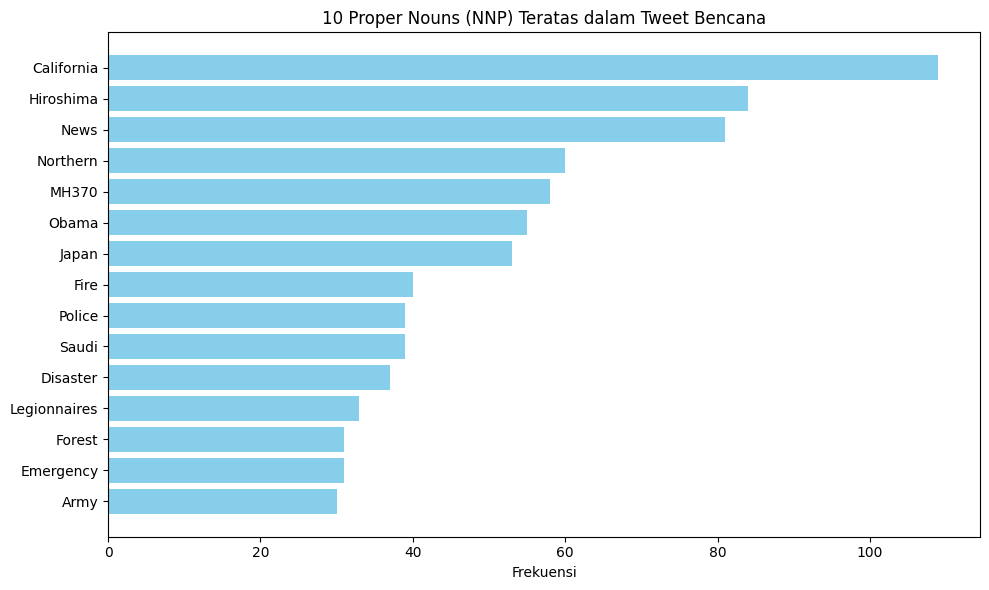

In [ ]:
# 4. Plot
labels, counts = zip(*top_nouns)
plt.figure(figsize=(10,6))
plt.barh(labels[::-1], counts[::-1], color='skyblue')  # reverse for highest on top
plt.xlabel("Frekuensi")
plt.title("10 Proper Nouns (NNP) Teratas dalam Tweet Bencana")
plt.tight_layout()
plt.show()

### NER BIO Tagging

In [ ]:
df_BIO = disaster_df.copy()

In [ ]:
from nltk.tokenize import word_tokenize
import spacy

nlp = spacy.load("en_core_web_sm")

def ner_bio(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    tags = []

    for token in doc:
        ent = token.ent_iob_  # 'B', 'I', 'O'
        label = token.ent_type_
        if ent == 'O':
            tags.append('O')
        else:
            tags.append(f"{ent}-{label}")

    return list(zip(tokens, tags))

# Contoh penggunaan
print(ner_bio("Explosion reported in Beirut downtown"))


[('Explosion', 'O'), ('reported', 'O'), ('in', 'O'), ('Beirut', 'B-GPE'), ('downtown', 'O')]


In [ ]:
def ner_bio2(text):
    doc = nlp(text)
    loc = []
    datetime = []
    org = []
    event = []

    for token in doc:
        ent = token.ent_iob_  # 'B', 'I', 'O'
        label = token.ent_type_
        if label in ['GPE', 'LOC']: #['GPE', 'LOC', 'DATE', 'TIME', 'ORG', 'EVENT']:
            loc.append(str(token))
        if label in ['DATE', 'TIME']:
            datetime.append(str(token))
        if label == 'ORG':
            org.append(str(token))
        if label == 'EVENT':
            event.append(str(token))

    loc = " ".join(loc)
    datetime = " ".join(datetime)
    org = " ".join(org)
    event = " ".join(event)

    return loc, datetime, org, event

# Contoh penggunaan
ner_bio2("'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'")

('Northern California Wildfire -', '', '', '')

In [ ]:
df_BIO['BIO-label'] = df_BIO['text'].apply(ner_bio)
df_BIO[['location', 'datetime', 'organizations', 'event']] = df_BIO['text'].apply(lambda x: pd.Series(ner_bio2(x)))

In [ ]:
df_BIO

,text,BIO-label,location,datetime,organizations,event
0,Our Deeds are the Reason of this #earthquake M...,"[(Our, O), (Deeds, O), (are, O), (the, O), (Re...",,,May ALLAH Forgive,
1,Forest fire near La Ronge Sask. Canada,"[(Forest, O), (fire, O), (near, O), (La, B-FAC...",Canada,,,
2,All residents asked to 'shelter in place' are ...,"[(All, O), (residents, O), (asked, O), (to, O)...",,,,
3,"13,000 people receive #wildfires evacuation or...","[(13,000, B-CARDINAL), (people, O), (receive, ...",California,,,
4,Just got sent this photo from Ruby #Alaska as ...,"[(Just, O), (got, O), (sent, O), (this, O), (p...",Alaska,,,
...,...,...,...,...,...,...
3266,Two giant cranes holding a bridge collapse int...,"[(Two, B-CARDINAL), (giant, O), (cranes, O), (...",,,,
3267,@aria_ahrary @TheTawniest The out of control w...,"[(@aria_ahrary, O), (@TheTawniest, O), (The, O...",California,,,
3268,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,"[(M1.94, O), ([, O), (01:04, B-CARDINAL), (UTC...",,,,
3269,Police investigating after an e-bike collided ...,"[(Police, O), (investigating, O), (after, O), ...",Portugal,,,


/tmp/ipython-input-50-1869115039.py:26: UserWarning: Glyph 137 (\x89) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


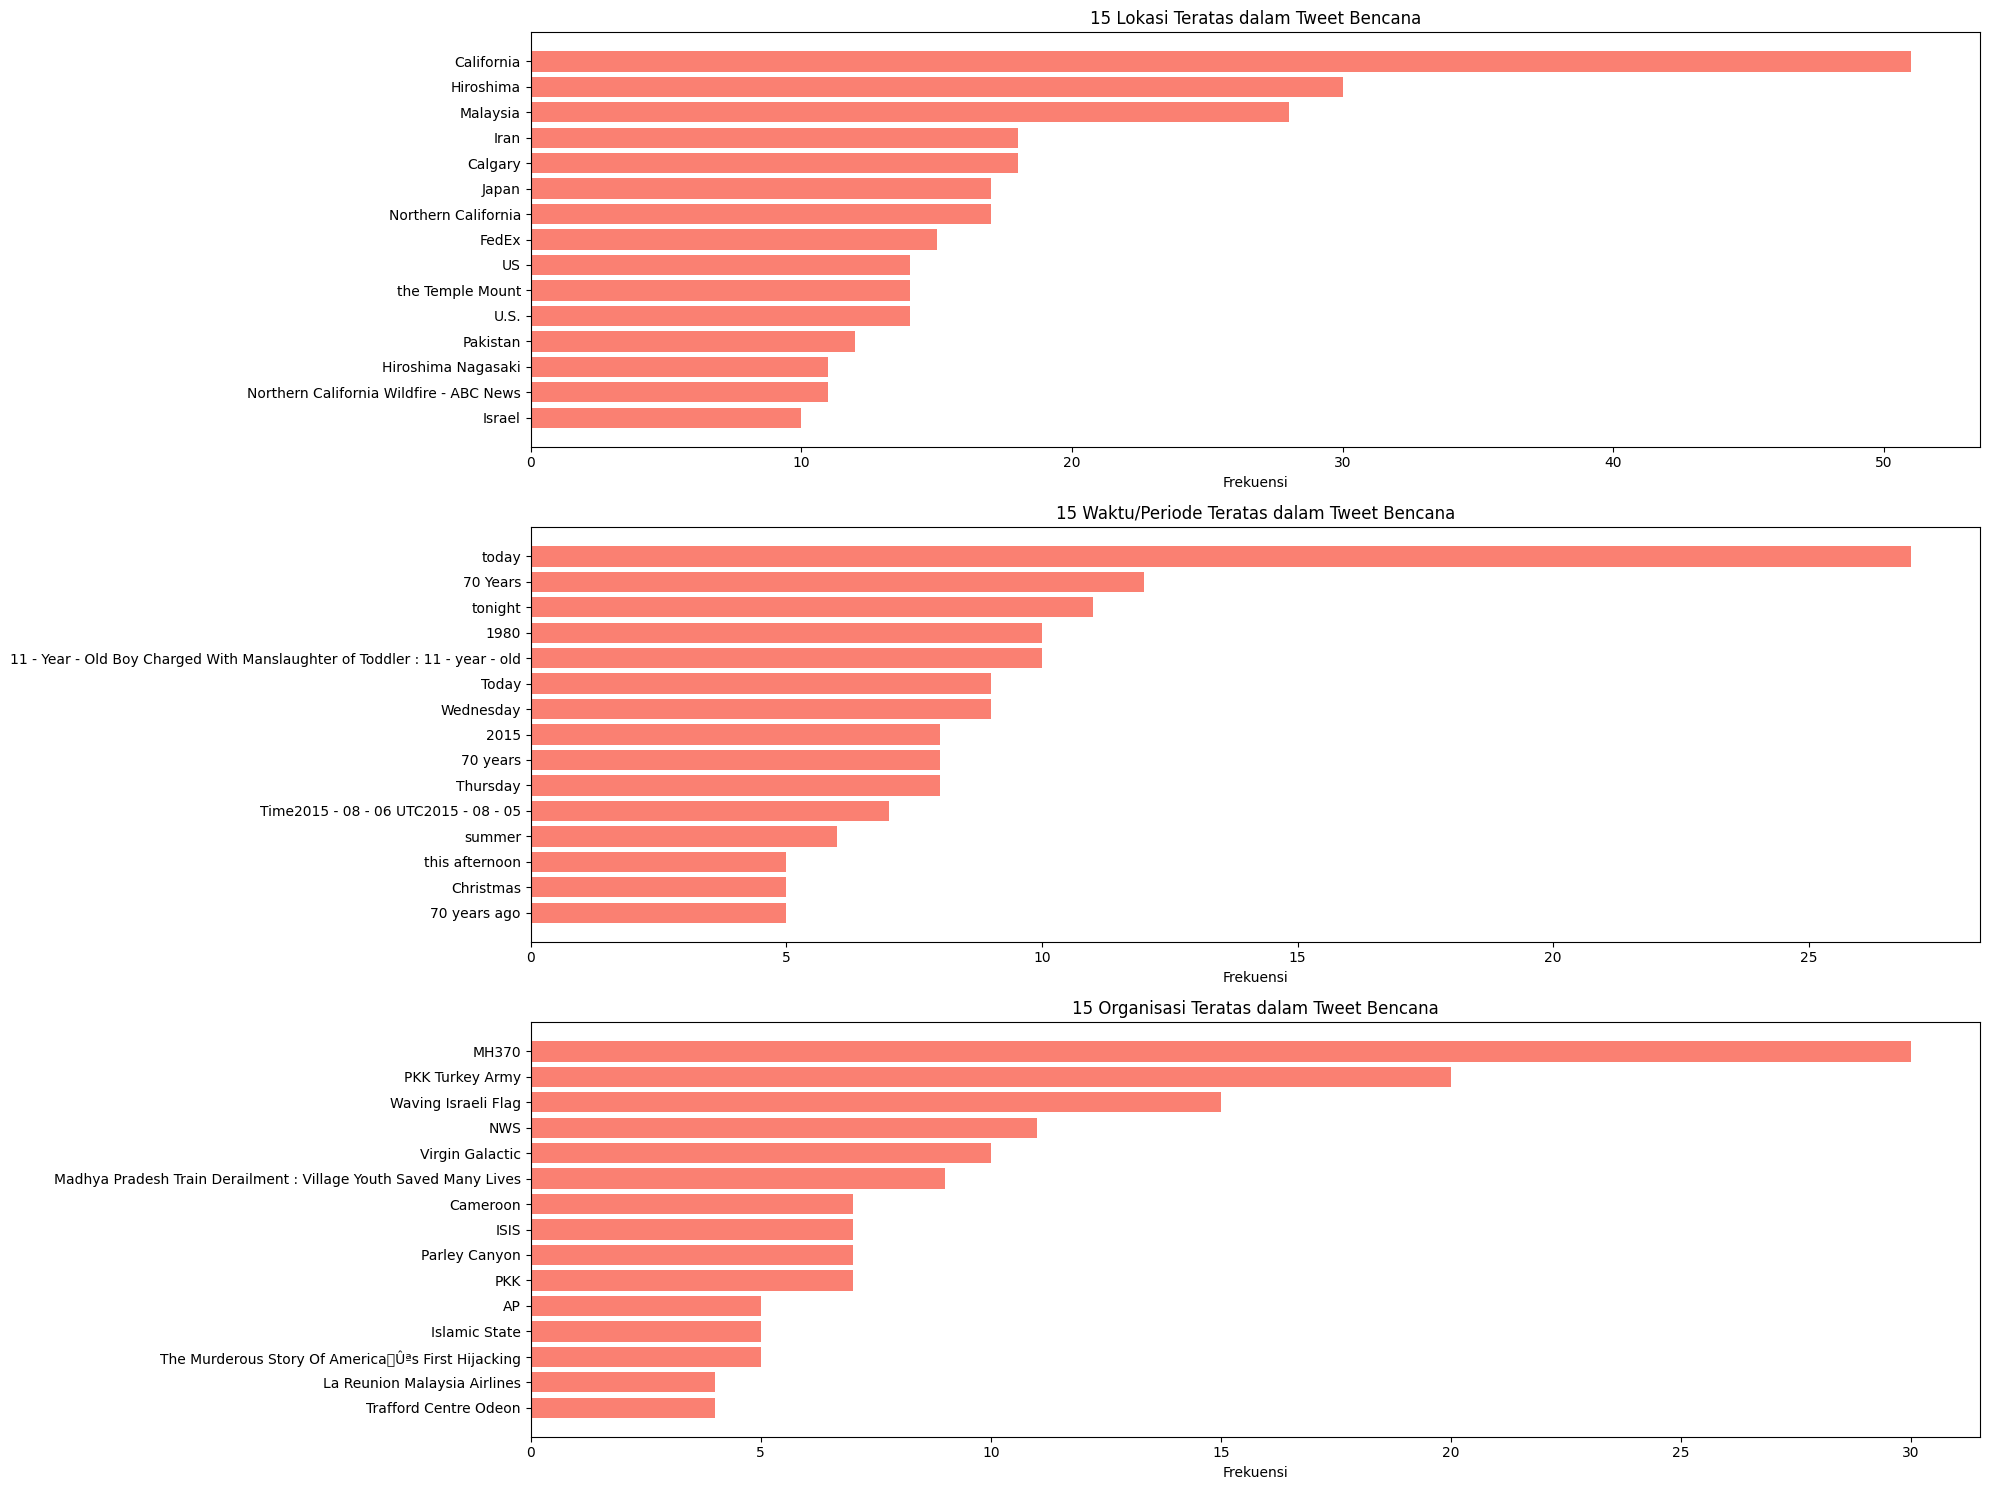

In [ ]:
columns_to_plot = ['location', 'datetime', 'organizations']
titles = ['15 Lokasi Teratas dalam Tweet Bencana',
          '15 Waktu/Periode Teratas dalam Tweet Bencana',
          '15 Organisasi Teratas dalam Tweet Bencana']

# --- Setup figure dengan 3 subplots (1 kolom, 3 baris) ---
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))

for i, (col, title) in enumerate(zip(columns_to_plot, titles)):
    # Ambil 15 nilai terbanyak, skip index ke-0 kalau isinya kosong
    counts = df_BIO[col].value_counts()
    if counts.index[0] == "":
        counts = counts.iloc[1:16]
    else:
        counts = counts.iloc[:15]

    labels = counts.index
    values = counts.values

    # Plot
    axes[i].barh(labels, values, color='salmon')
    axes[i].set_title(title)
    axes[i].set_xlabel("Frekuensi")
    axes[i].invert_yaxis()  # agar nilai terbesar di atas

plt.tight_layout()
plt.show()